# Description

This notebook provides a first look at the FC matrices that form this data sample:

* Load all connectivity matrices

* Compute the average connectivity matrix across the whole sample

* Plot the average FC for the whole sample

* Create dashboard to fastly explore all the individual scan FC matrices

In [5]:
import pandas as pd
import xarray as xr
import numpy as np
import os.path as osp
import hvplot.pandas
from tqdm import tqdm
import matplotlib.pyplot as plt
#import holoviews as hv
from utils.basics import get_sbj_scan_list
from scipy.spatial.distance import squareform
from utils.basics import DATA_DIR, CORTICAL_400ROI_ATLAS_NAME, FB_400ROI_ATLAS_NAME, ATLASES_DIR, FB_200ROI_ATLAS_NAME
from utils.plotting import hvplot_fc, plot_fc
from sfim_lib.io.afni import load_netcc
from scipy.spatial.distance import cosine      as cosine_distance
from scipy.spatial.distance import correlation as correlation_distance
from scipy.spatial.distance import euclidean   as euclidean_distance
import seaborn as sns
import panel as pn
from sklearn.utils.validation import check_symmetric

In [6]:
import os
port_tunnel = int(os.environ['PORT2'])
print('++ INFO: Second Port available: %d' % port_tunnel)

++ INFO: Second Port available: 46709


In [7]:
ATLAS_NAME = FB_200ROI_ATLAS_NAME

# 1. Load the final list of scans used in this project

In [8]:
sbj_list, scan_list = get_sbj_scan_list(when='post_motion', return_snycq=False)

++ [post_motion] Number of subjects: 133 subjects
++ [post_motion] Number of scans:    471 scans


# 2. Load information about the Atlas and ROI needed for plotting

In [10]:
ATLASINFO_PATH = osp.join(ATLASES_DIR,ATLAS_NAME,f'{ATLAS_NAME}.roi_info.csv')
roi_info       = pd.read_csv(ATLASINFO_PATH)
roi_info

ROI_ID Hemisphere      Network                 ROI_Name  pos_R  pos_A  \
0         1         LH          Vis                 LH_Vis_1    -24    -54   
1         2         LH          Vis                 LH_Vis_2    -26    -78   
2         3         LH          Vis                 LH_Vis_3    -46    -70   
3         4         LH          Vis                 LH_Vis_4    -10    -68   
4         5         LH          Vis                 LH_Vis_5    -26    -96   
..      ...        ...          ...                      ...    ...    ...   
190     191         RH      Default     RH_Default_pCunPCC_3      6    -58   
191     192         RH  Subcortical   RH_Subcortical_Caudate     14     13   
192     193         RH  Subcortical   RH_Subcortical_Putamen     26      4   
193     194         RH  Subcortical  RH_Subcortical_Pallidum     22      0   
194     195         RH  Subcortical  RH_Subcortical_Thalamus     12    -18   

     pos_S  color_R  color_G  color_B      RGB  
0      -10      120       18      129  #781281  
1      -14      120       18      130  #781282  
2       -8      120       18      131  #781283  
3       -4      120       18      132  #781284  
4      -12      120       18      133  #781285  
..     ...      ...      ...      ...      ...  
190     44      208       63       77  #d03f4d  
191     -7      255      255        0  #ffff00  
192     -1      255      255        0  #ffff00  
193      0      255      255        0  #ffff00  
194     -6      255      255        0  #ffff00  

[195 rows x 11 columns]

# 3. Load into memory all individual scan FC matrices

We will place the matrices in two separate xr.DataArray data structures. One will hold the matrices in terms of Pearson's correlation (```all_sfc_R```) and the other one in terms of their Fisher's transform (```all_sfc_Z```). In the first cell below, we create empty versions of these two data structures. These empty data structures will get populated in the subsequent cell.

In [11]:
unique_sbj_ids = list(pd.Series([sbj for sbj,_ in scan_list]).unique())
unique_run_ids = list(pd.Series([run for _,run in scan_list]).unique())

In [12]:
# Create empty Xr Data Array to hold all FC matrices
all_sfc_R = xr.DataArray(dims=['Subject','Run','ROI1','ROI2'], 
                         coords={'Subject':unique_sbj_ids,
                                 'Run': unique_run_ids,
                                 'ROI1':roi_info['ROI_Name'].values,
                                 'ROI2':roi_info['ROI_Name'].values})
all_sfc_Z = xr.DataArray(dims=['Subject','Run','ROI1','ROI2'], 
                         coords={'Subject':unique_sbj_ids,
                                 'Run': unique_run_ids,
                                 'ROI1':roi_info['ROI_Name'].values,
                                 'ROI2':roi_info['ROI_Name'].values})

In [14]:
%%time
all_rois = list(roi_info['ROI_Name'].values)
# Load all matrices
for sbj,run in tqdm(scan_list):
    _,_,_,_,run_num,_,run_acq = run.split('-')
    netcc_path = osp.join(DATA_DIR,'PrcsData',sbj,'preprocessed','func','pb06_staticFC',f'{run_acq}_run-{run_num}.{ATLAS_NAME}_000.netcc')
    netcc      = load_netcc(netcc_path)
    this_scan_rois = [ item.strip().strip('7Networks_') for item in list(netcc.columns)]
    all_sfc_R.loc[sbj,run,:,:] = netcc
    all_sfc_Z.loc[sbj,run,:,:] = netcc.apply(np.arctanh)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 471/471 [00:15<00:00, 31.36it/s]

CPU times: user 5.02 s, sys: 416 ms, total: 5.44 s
Wall time: 15 s


# 4. Compute the average matrix for the whole sample

To compute the sample mean, we first Fisher's transform each individual matrix, average those, and do the inverse transform of the average

In [15]:
REFERENCE_fc = np.tanh(all_sfc_Z.mean(dim=['Subject','Run'])).values

Put the matrix into a properly annotated DataFrame structure

In [16]:
REFERENCE_fc = pd.DataFrame(REFERENCE_fc, columns=list(roi_info['ROI_Name']),index=list(roi_info['ROI_Name']))
REFERENCE_fc.index.name   = 'ROI1'
REFERENCE_fc.columns.name = 'ROI2'

Plot the sample mean (or Reference) FC matrix

In [17]:
hvplot_fc(REFERENCE_fc, ATLASINFO_PATH, cbar_title='Average FC for the whole sample')

:Overlay
   .HeatMap.I   :HeatMap   [columns,index]   (value)
   .HLine.I     :HLine   [x,y]
   .VLine.I     :VLine   [x,y]
   .HLine.II    :HLine   [x,y]
   .VLine.II    :VLine   [x,y]
   .HLine.III   :HLine   [x,y]
   .VLine.III   :VLine   [x,y]
   .HLine.IV    :HLine   [x,y]
   .VLine.IV    :VLine   [x,y]
   .HLine.V     :HLine   [x,y]
   .VLine.V     :VLine   [x,y]
   .HLine.VI    :HLine   [x,y]
   .VLine.VI    :VLine   [x,y]
   .HLine.VII   :HLine   [x,y]
   .VLine.VII   :VLine   [x,y]
   .HLine.VIII  :HLine   [x,y]
   .VLine.VIII  :VLine   [x,y]
   .HLine.IX    :HLine   [x,y]
   .VLine.IX    :VLine   [x,y]
   .HLine.X     :HLine   [x,y]
   .VLine.X     :VLine   [x,y]
   .HLine.XI    :HLine   [x,y]
   .VLine.XI    :VLine   [x,y]
   .HLine.XII   :HLine   [x,y]
   .VLine.XII   :VLine   [x,y]
   .HLine.XIII  :HLine   [x,y]
   .VLine.XIII  :VLine   [x,y]
   .HLine.XIV   :HLine   [x,y]
   .VLine.XIV   :VLine   [x,y]
   .HLine.XV    :HLine   [x,y]
   .VLine.XV    :VLine   [x,y]
   .Segments.I  :Segments   [x0,y0,x1,y1]   (Hemispheres)
   .Segments.II :Segments   [x0,y0,x1,y1]   (Networks)

# 5. Comput average FC matrix per subject (in case we want to explore those)

In [18]:
sbj_level_sfc_R = np.arctan(all_sfc_Z.mean(dim='Run'))

In [19]:
sbj_select = pn.widgets.Select(name='Subject', options=unique_sbj_ids)
@pn.depends(sbj_select)
def plot_subject_fc(sbj):
    this_subject_mat = pd.DataFrame(sbj_level_sfc_R.loc[sbj].values, index=list(sbj_level_sfc_R.coords['ROI1'].values), columns=list(sbj_level_sfc_R.coords['ROI2'].values))
    return hvplot_fc(this_subject_mat, ATLASINFO_PATH, cbar_title='FC '+sbj)
sbj_mat_dashboard = pn.Row(sbj_select, plot_subject_fc)

In [20]:
sbj_mat_dashboard_server = sbj_mat_dashboard.show(port=port_tunnel,open=False)

Launching server at http://localhost:46709


In [21]:
sbj_mat_dashboard_server.stop()

## 4.1. Vectorize Reference FC Matrix

For many subsequent operations it is necessary to go back and forth between the full matrix and its vectorized version (e.g., only the values in the top triangular half). 

The following code allows to do that tansformation and the retain information about the ROI pairs associated with each entry of the vectorized version of the matrices.

In [22]:
Nrois  = REFERENCE_fc.shape[0]          # Number of ROIs
Nconns = int(Nrois * (Nrois-1) / 2)     # Number of Connections

This cell vectorized the REFERENCE matrix into a numpy array

In [23]:
# Create a vectorized version of the sample mean FC
REFERENCE_fc_array = REFERENCE_fc.values.copy()
np.fill_diagonal(REFERENCE_fc_array,0)              # scipy squareform only takes as input symmetric matrices with zeros on the diagonal
REFERENCE_fc_VECT = squareform(REFERENCE_fc_array)
assert Nconns == len(REFERENCE_fc_VECT)             # ensuring the output has the correct number of items

<AxesSubplot:>

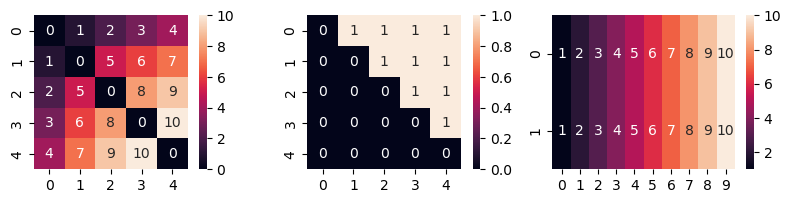

In [24]:
# Code to ensure that there is agreement between using squareform and using trui to select the top triangle of a symmetric matrix
# There are different ways in which one can go from symm matrix to vector. One can go up and down the columns or left to right on 
# the rows. Scipy squareform does the latter. As we cannot use that function to vectorized our array with ROI names, we needed to
# find an alternative based on np.triu. This cell is just a sanity check that our procedure for extracting conn names will be co-
# rrect.

example_square_mat   = np.array([[0,1,2,3,4],[1,0,5,6,7],[2,5,0,8,9],[3,6,8,0,10],[4,7,9,10,0]])
top_triangle_idx_mat = np.triu(np.ones(example_square_mat.shape),1)
top_triangle_idx_mat = top_triangle_idx_mat.astype(bool)
selected_values_a    = example_square_mat[top_triangle_idx_mat]
selected_values_b    = squareform(example_square_mat)
#idx = idx.astype(bool)
fig, axs = plt.subplots(1,3,figsize=(10,2))
sns.heatmap(example_square_mat,   annot=True, square=True, ax=axs[0])
sns.heatmap(top_triangle_idx_mat, annot=True, square=True, ax=axs[1])
sns.heatmap([selected_values_a, selected_values_b], annot=True, ax=axs[2])

This cell will obtian the name of each connection in the vector, which we will subsequently used as an index to a pandas.Series structure that will hold the vectorized version of the Reference FC matrix

In [25]:
conn_names = pd.DataFrame(index=range(Nrois), columns=range(Nrois))
roi_names = roi_info['ROI_Name']
for i,roi1 in enumerate(roi_names):
    for j,roi2 in enumerate(roi_names):
        conn_names.loc[i,j]=(roi1,roi2)
conn_names_triu_idx_mat = np.triu(np.ones(conn_names.shape),1)
conn_names_triu_idx_mat = conn_names_triu_idx_mat.astype(bool)
conn_names_VECT = conn_names.values[conn_names_triu_idx_mat]

In [26]:
REFERENCE_fc_VECT = pd.Series(REFERENCE_fc_VECT, index=conn_names_VECT)
REFERENCE_fc_VECT.name = 'Sample FC'
REFERENCE_fc_VECT.head(5)

(LH_Vis_1, LH_Vis_2)    0.646192
(LH_Vis_1, LH_Vis_3)    0.485404
(LH_Vis_1, LH_Vis_4)    0.687994
(LH_Vis_1, LH_Vis_5)    0.164052
(LH_Vis_1, LH_Vis_6)    0.598237
Name: Sample FC, dtype: float64

## 4.2. Create Sorting index for connections

The interpretability of FC matrices and their vectorized versions can change significantly depending on how entries are sorted. The content of the matrix is the same, but its visual appearance can drastically change.

To evaluate if there is any differences in across-subject variability between within- and across-network connections and/or connections between primary regions and those associated with hihgher order cognitive functions, the next cell creates a sorted index for the connections axis that we will use during plotting. In particular, we creare an index that lists first all intra-network connections, followed by connections between primary and higher order networks and finalized with connections between two regions from higher order cognitive networks. 

In [27]:
anat_sorting            = [ ]
anat_sorting_blocks     = [ ]
net_names    = list(roi_info['Network'].unique())
hm_names     = ['LH','RH']
# Within Network Connections
init = len(anat_sorting)
for nw in net_names:
    anat_sorting = anat_sorting + [(roi1,roi2) for roi1,roi2 in conn_names_VECT if (nw in roi1) and (nw in roi2)]
end  = len(anat_sorting)
anat_sorting_blocks.append(('Within',init,end))
# Primary Vis / Som to everything else
init = len(anat_sorting)
for nw in ['Vis','SomMot']:
    anat_sorting = anat_sorting + [(roi1,roi2) for roi1,roi2 in conn_names_VECT if ((roi1,roi2) not in anat_sorting) & ((nw in roi1) | (nw in roi2)) ]
end  = len(anat_sorting)
anat_sorting_blocks.append(('Primary <-> Higher',init,end))
# Everything else
init = len(anat_sorting)
anat_sorting = anat_sorting + [(roi1,roi2) for roi1,roi2 in conn_names_VECT if ((roi1,roi2) not in anat_sorting)]
end  = len(anat_sorting)
anat_sorting_blocks.append(('Higher <-> Higher',init,end))
anat_sorting_blocks

[('Within', 0, 3010),
 ('Primary <-> Higher', 3010, 12409),
 ('Higher <-> Higher', 12409, 18915)]

# 5. Compute Vectorized versions of all individual scan FC

In [29]:
all_sfc_R_VECT = pd.DataFrame(index=np.arange(Nconns),columns=[sbj+'|'+run for sbj,run in scan_list])
for sbj,run in tqdm(scan_list):
    scan_label          = sbj+'|'+run 
    this_scan_fc_matrix = all_sfc_R.loc[sbj,run].values
    np.fill_diagonal(this_scan_fc_matrix,0)
    this_scan_fc_vector = squareform(this_scan_fc_matrix)
    all_sfc_R_VECT[scan_label] = this_scan_fc_vector
all_sfc_R_VECT.index        = conn_names_VECT
all_sfc_R_VECT.index.name   = 'Connections'
all_sfc_R_VECT.columns.name = 'Scans'
all_sfc_R_VECT.head(5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 471/471 [00:15<00:00, 29.95it/s]


Scans                 sub-010014|post-ses-02-run-01-acq-AP  \
Connections                                                  
(LH_Vis_1, LH_Vis_2)                                0.7259   
(LH_Vis_1, LH_Vis_3)                                0.1625   
(LH_Vis_1, LH_Vis_4)                                0.6993   
(LH_Vis_1, LH_Vis_5)                                0.3240   
(LH_Vis_1, LH_Vis_6)                                0.7246   

Scans                 sub-010014|post-ses-02-run-01-acq-PA  \
Connections                                                  
(LH_Vis_1, LH_Vis_2)                                0.5608   
(LH_Vis_1, LH_Vis_3)                                0.0517   
(LH_Vis_1, LH_Vis_4)                                0.6197   
(LH_Vis_1, LH_Vis_5)                                0.0209   
(LH_Vis_1, LH_Vis_6)                                0.7278   

Scans                 sub-010014|post-ses-02-run-02-acq-AP  \
Connections                                                  
(LH_Vis_1, LH_Vis_2)                                0.4039   
(LH_Vis_1, LH_Vis_3)                                0.0706   
(LH_Vis_1, LH_Vis_4)                                0.6778   
(LH_Vis_1, LH_Vis_5)                               -0.0101   
(LH_Vis_1, LH_Vis_6)                                0.6587   

Scans                 sub-010014|post-ses-02-run-02-acq-PA  \
Connections                                                  
(LH_Vis_1, LH_Vis_2)                                0.5761   
(LH_Vis_1, LH_Vis_3)                                0.3146   
(LH_Vis_1, LH_Vis_4)                                0.6299   
(LH_Vis_1, LH_Vis_5)                                0.0907   
(LH_Vis_1, LH_Vis_6)                                0.6720   

Scans                 sub-010080|post-ses-02-run-02-acq-AP  \
Connections                                                  
(LH_Vis_1, LH_Vis_2)                                0.5198   
(LH_Vis_1, LH_Vis_3)                                0.4900   
(LH_Vis_1, LH_Vis_4)                                0.7276   
(LH_Vis_1, LH_Vis_5)                                0.1485   
(LH_Vis_1, LH_Vis_6)                                0.4997   

Scans                 sub-010080|post-ses-02-run-02-acq-PA  \
Connections                                                  
(LH_Vis_1, LH_Vis_2)                                0.7363   
(LH_Vis_1, LH_Vis_3)                                0.6586   
(LH_Vis_1, LH_Vis_4)                                0.7827   
(LH_Vis_1, LH_Vis_5)                                0.3434   
(LH_Vis_1, LH_Vis_6)                                0.7131   

Scans                 sub-010082|post-ses-02-run-01-acq-AP  \
Connections                                                  
(LH_Vis_1, LH_Vis_2)                                0.3000   
(LH_Vis_1, LH_Vis_3)                                0.1034   
(LH_Vis_1, LH_Vis_4)                                0.2235   
(LH_Vis_1, LH_Vis_5)                                0.0697   
(LH_Vis_1, LH_Vis_6)                                0.6576   

Scans                 sub-010082|post-ses-02-run-01-acq-PA  \
Connections                                                  
(LH_Vis_1, LH_Vis_2)                                0.4471   
(LH_Vis_1, LH_Vis_3)                                0.2921   
(LH_Vis_1, LH_Vis_4)                                0.3139   
(LH_Vis_1, LH_Vis_5)                                0.0776   
(LH_Vis_1, LH_Vis_6)                                0.5679   

Scans                 sub-010082|post-ses-02-run-02-acq-PA  \
Connections                                                  
(LH_Vis_1, LH_Vis_2)                                0.2978   
(LH_Vis_1, LH_Vis_3)                                0.3047   
(LH_Vis_1, LH_Vis_4)                                0.2500   
(LH_Vis_1, LH_Vis_5)                                0.0733   
(LH_Vis_1, LH_Vis_6)                                0.6114   

Scans                 sub-010084|post-ses-02-run-01-acq-AP  ...  \
Connections       

# 6. Compute Similarity to REFERENCE Matrix (corr, cov, cosine) and get sorted list of scans

First, we will compute the Pearson's Correlation between the vectorized version of the reference FC matrix and those from each individual scan

In [30]:
corr_to_REFERENCE    = all_sfc_R_VECT.corrwith(pd.Series(REFERENCE_fc_VECT))
corr_to_REFERENCE.name = 'R'

Second, we will compute the covariance

In [31]:
cov_to_REFERENCE = pd.Series(dtype=float)
for sbj,run in scan_list:
    scan_label = sbj+'|'+run
    aux        = all_sfc_R_VECT[scan_label]
    cov_to_REFERENCE[scan_label] = np.cov(REFERENCE_fc_VECT,aux)[0,1]
cov_to_REFERENCE.name = 'cov'

Third, we compute the Correlation distance (1-R): Dc = 0 (fully correlated) | Dc = 1 (not correlated) | Dc = 2 (anticorrelated)

In [32]:
Dcor_to_REFERENCE = pd.Series(dtype=float)
for sbj,run in scan_list:
    scan_label = sbj+'|'+run
    aux        = all_sfc_R_VECT[scan_label]
    Dcor_to_REFERENCE[scan_label] = correlation_distance(REFERENCE_fc_VECT,aux)
Dcor_to_REFERENCE.name = 'Dr'

Fourth, we will compute the cosine distance: 0 = same vector (zero angle) | 1 = orthogonal (90 degrees) | 2 = oposite (180 degrees) ]

In [33]:
Dcos_to_REFERENCE = pd.Series(dtype=float)
for sbj,run in scan_list:
    scan_label = sbj+'|'+run
    aux        = all_sfc_R_VECT[scan_label]
    Dcos_to_REFERENCE[scan_label] = cosine_distance(REFERENCE_fc_VECT,aux)
Dcos_to_REFERENCE.name = 'Dcos'

Fifth, we will compute the euclidean distance

In [34]:
Deuc_to_REFERENCE = pd.Series(dtype=float)
for sbj,run in scan_list:
    scan_label = sbj+'|'+run
    aux        = all_sfc_R_VECT[scan_label]
    Deuc_to_REFERENCE[scan_label] = euclidean_distance(REFERENCE_fc_VECT,aux)
Deuc_to_REFERENCE.name = 'Deuc'

We will use these similarity and disimilarity metrix to sort scans (for visualization purposes)

In [35]:
scan_list_sorted={'none':['|'.join([sbj,run]) for sbj,run in scan_list],
                  'correlation':list(corr_to_REFERENCE.sort_values(ascending=False).index),
                  'covariance':list(cov_to_REFERENCE.sort_values(ascending=False).index),
                  'cosine distance':list(Dcos_to_REFERENCE.sort_values(ascending=False).index),
                  'correlation distance':list(Dcor_to_REFERENCE.sort_values(ascending=False).index),
                  'euclidean distance':list(Deuc_to_REFERENCE.sort_values(ascending=False).index),}

In [36]:
scan_sort_method_select = pn.widgets.Select(name='Scan Sort Method', options=list(scan_list_sorted.keys()), value='none')
conn_sort_method_select = pn.widgets.Select(name='Conn Sort Method', options=['none','network'],            value='none')

@pn.depends(scan_sort_method_select,conn_sort_method_select)
def plot_carpet(scan_sorting_method, conn_sort_method):
    if conn_sort_method == 'none':
        conn_list = list(all_sfc_R_VECT.index)
    if conn_sort_method == 'network':
        conn_list = anat_sorting
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    plot = sns.heatmap(all_sfc_R_VECT.loc[conn_list,scan_list_sorted[scan_sorting_method]],cmap='RdBu_r', vmin=-.8, vmax=.8, xticklabels=False, yticklabels=False)
    plot.set_xlabel('Scans', fontsize=14)
    plot.set_ylabel('Connections', fontsize=14)
    ytick_locs, ytick_labs = [],[]
    if conn_sort_method is 'network':
        for name,init,end in anat_sorting_blocks:
            ytick_locs = ytick_locs + [init + ((end-init)/2)]
            ytick_labs = ytick_labs + [name]
            plt.plot([0,Nconns],[end,end],'k--',lw=1)
            plt.plot([0,Nconns],[init,init],'k--',lw=1)
        ax.set_yticks(ytick_locs, fontsize=8);
        ax.set_yticklabels(ytick_labs, fontsize=9, rotation=90, va='center'); 
    plt.close()
    return fig
dashboard01 = pn.Row(pn.Card(scan_sort_method_select,conn_sort_method_select,title='Options'),pn.Card(plot_carpet,title='Carpet Plot of FC for the whole dataset'))

In [37]:
dashboard01_server = dashboard01.show(port=port_tunnel,open=False)

Launching server at http://localhost:46709


In [38]:
dashboard01_server.stop()

# 7. Plot Distribution of correlatations towards the REFERENCE

In [39]:
((corr_to_REFERENCE.hvplot.hist(bins=50, normed=True, title='R(Scan,REF)', xlabel='Correlation to Sample Mean', ylabel='Distribution', fontsize=14, xlim=(0,1), width=500) \
* corr_to_REFERENCE.hvplot.kde()) + \
(cov_to_REFERENCE.hvplot.hist(bins=50, normed=True, title='Cov(Scan,REF)', xlabel='Covariance to Sample Mean', ylabel='Distribution', fontsize=14, width=500) \
* cov_to_REFERENCE.hvplot.kde()) + \
(Dcor_to_REFERENCE.hvplot.hist(bins=50, normed=True, title='Dcorr(Scan,REF)', xlabel='Correlation Distance to Sample Mean', ylabel='Distribution', fontsize=14, xlim=(0,1), width=500) \
* Dcor_to_REFERENCE.hvplot.kde()) + \
(Dcos_to_REFERENCE.hvplot.hist(bins=50, normed=True, title='Dcos(Scan,REF)', xlabel='Cosine Distance to Sample Mean', ylabel='Distribution', fontsize=14, width=500) \
* Dcos_to_REFERENCE.hvplot.kde()) + \
(Deuc_to_REFERENCE.hvplot.hist(bins=50, normed=True, title='Deuc(Scan,REF)', xlabel='Euclidean Distance to Sample Mean', ylabel='Distribution', fontsize=14, width=500) \
* Deuc_to_REFERENCE.hvplot.kde())).cols(3)

:Layout
   .Overlay.I   :Overlay
      .Histogram.I    :Histogram   [R]   (R_frequency)
      .Distribution.I :Distribution   [R]   (Density)
   .Overlay.II  :Overlay
      .Histogram.I    :Histogram   [cov]   (cov_frequency)
      .Distribution.I :Distribution   [cov]   (Density)
   .Overlay.III :Overlay
      .Histogram.I    :Histogram   [Dr]   (Dr_frequency)
      .Distribution.I :Distribution   [Dr]   (Density)
   .Overlay.IV  :Overlay
      .Histogram.I    :Histogram   [Dcos]   (Dcos_frequency)
      .Distribution.I :Distribution   [Dcos]   (Density)
   .Overlay.V   :Overlay
      .Histogram.I    :Histogram   [Deuc]   (Deuc_frequency)
      .Distribution.I :Distribution   [Deuc]   (Density)

# 8. Generate dashboard to explore all individual scan FC matrices

> **NOTE**: If you run the code within the notebook, the dashboard does not update when you hit play. Make sure to open it by clicking on the URL that the show command below returns

In [40]:
# This is needed to ensure the labels are not cut when serving the matplotlib figures via pn.Column
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [44]:
Nscans          = len(scan_list)
scan_selector   = pn.widgets.Player(name='Scan Number', start=0, end=Nscans-1, value=0, width=700)
@pn.depends(scan_selector,scan_sort_method_select)
def plot_one_scan(scan_num,sorting_method):
    aux_scan_list             = scan_list_sorted[sorting_method]
    scan_name                 = aux_scan_list[scan_num]
    sbj, run                  = scan_name.split('|')
    _,_,_,_,run_num,_,run_acq = (run).split('-')
    scan_label = sbj + ',' + run_num+'_'+run_acq + ' | R = %.3f' % corr_to_REFERENCE[scan_name]  + ' | Cov = %.2f' % cov_to_REFERENCE[scan_name] + ' | DCos = %.2f' % Dcos_to_REFERENCE[scan_name] + ' | DCor = %.2f' % Dcor_to_REFERENCE[scan_name] + ' | DEuc = %.2f' % Deuc_to_REFERENCE[scan_name]
    data = all_sfc_R.loc[sbj,run].values
    fig  = plot_fc(data,ATLASINFO_PATH, figsize=(10,10))
    #return pn.Card(fig,title=scan_label,collapsible=False)
    return pn.Card(pn.pane.Matplotlib(fig),title=scan_label,collapsible=False)

In [45]:
dashboard = pn.Column(pn.Card(scan_sort_method_select,scan_selector,title='Options'),plot_one_scan)

In [46]:
dashboard_server = dashboard.show(port=port_tunnel,open=False)

Launching server at http://localhost:46709


In [47]:
# Once you are done looking at matrices, you can stop the server running this cell
dashboard_server.stop()

# 8. Explore extreme cases

### Show the matrix most different to the sample mean

In [49]:
most_different_scan      = corr_to_REFERENCE.sort_values().index[0]
most_different_scan_corr = corr_to_REFERENCE.sort_values()[0]
print('INFO: Most dissimilar scan to the sample mean [%s --> R(scan,mean) = %.2f ]' % (most_different_scan,most_different_scan_corr))
sbj,run = most_different_scan.split('|')
most_different_matrix = all_sfc_R.loc[sbj,run,:,:].values
np.fill_diagonal(most_different_matrix,1)
hvplot_fc(most_different_matrix, ATLASINFO_PATH)

INFO: Most dissimilar scan to the sample mean [sub-010231|post-ses-02-run-02-acq-AP --> R(scan,mean) = 0.60 ]


:Overlay
   .HeatMap.I   :HeatMap   [columns,index]   (value)
   .HLine.I     :HLine   [x,y]
   .VLine.I     :VLine   [x,y]
   .HLine.II    :HLine   [x,y]
   .VLine.II    :VLine   [x,y]
   .HLine.III   :HLine   [x,y]
   .VLine.III   :VLine   [x,y]
   .HLine.IV    :HLine   [x,y]
   .VLine.IV    :VLine   [x,y]
   .HLine.V     :HLine   [x,y]
   .VLine.V     :VLine   [x,y]
   .HLine.VI    :HLine   [x,y]
   .VLine.VI    :VLine   [x,y]
   .HLine.VII   :HLine   [x,y]
   .VLine.VII   :VLine   [x,y]
   .HLine.VIII  :HLine   [x,y]
   .VLine.VIII  :VLine   [x,y]
   .HLine.IX    :HLine   [x,y]
   .VLine.IX    :VLine   [x,y]
   .HLine.X     :HLine   [x,y]
   .VLine.X     :VLine   [x,y]
   .HLine.XI    :HLine   [x,y]
   .VLine.XI    :VLine   [x,y]
   .HLine.XII   :HLine   [x,y]
   .VLine.XII   :VLine   [x,y]
   .HLine.XIII  :HLine   [x,y]
   .VLine.XIII  :VLine   [x,y]
   .HLine.XIV   :HLine   [x,y]
   .VLine.XIV   :VLine   [x,y]
   .HLine.XV    :HLine   [x,y]
   .VLine.XV    :VLine   [x,y]
   .Segments.I  :Segments   [x0,y0,x1,y1]   (Hemispheres)
   .Segments.II :Segments   [x0,y0,x1,y1]   (Networks)

### Show the matrix most similar to the sample mean

In [50]:
most_similar_scan      = corr_to_REFERENCE.sort_values(ascending=False).index[0]
most_similar_scan_corr = corr_to_REFERENCE.sort_values(ascending=False)[0]
print('INFO: Most dissimilar scan to the sample mean [%s --> R(scan,mean) = %.2f ]' % (most_similar_scan,most_similar_scan_corr))
sbj,run = most_similar_scan.split('|')
most_similar_matrix = all_sfc_R.loc[sbj,run,:,:].values
np.fill_diagonal(most_similar_matrix,1)
hvplot_fc(most_similar_matrix, ATLASINFO_PATH)

INFO: Most dissimilar scan to the sample mean [sub-010210|post-ses-02-run-01-acq-PA --> R(scan,mean) = 0.84 ]


:Overlay
   .HeatMap.I   :HeatMap   [columns,index]   (value)
   .HLine.I     :HLine   [x,y]
   .VLine.I     :VLine   [x,y]
   .HLine.II    :HLine   [x,y]
   .VLine.II    :VLine   [x,y]
   .HLine.III   :HLine   [x,y]
   .VLine.III   :VLine   [x,y]
   .HLine.IV    :HLine   [x,y]
   .VLine.IV    :VLine   [x,y]
   .HLine.V     :HLine   [x,y]
   .VLine.V     :VLine   [x,y]
   .HLine.VI    :HLine   [x,y]
   .VLine.VI    :VLine   [x,y]
   .HLine.VII   :HLine   [x,y]
   .VLine.VII   :VLine   [x,y]
   .HLine.VIII  :HLine   [x,y]
   .VLine.VIII  :VLine   [x,y]
   .HLine.IX    :HLine   [x,y]
   .VLine.IX    :VLine   [x,y]
   .HLine.X     :HLine   [x,y]
   .VLine.X     :VLine   [x,y]
   .HLine.XI    :HLine   [x,y]
   .VLine.XI    :VLine   [x,y]
   .HLine.XII   :HLine   [x,y]
   .VLine.XII   :VLine   [x,y]
   .HLine.XIII  :HLine   [x,y]
   .VLine.XIII  :VLine   [x,y]
   .HLine.XIV   :HLine   [x,y]
   .VLine.XIV   :VLine   [x,y]
   .HLine.XV    :HLine   [x,y]
   .VLine.XV    :VLine   [x,y]
   .Segments.I  :Segments   [x0,y0,x1,y1]   (Hemispheres)
   .Segments.II :Segments   [x0,y0,x1,y1]   (Networks)

In [52]:
median_selector          = corr_to_REFERENCE[corr_to_REFERENCE==corr_to_REFERENCE.median()]
median_similar_scan      = median_selector.index[0]
median_similar_scan_corr = median_selector.values
print('INFO: Scan with median similarity to the sample mean [%s --> R(scan,mean) = %.2f ]' % (median_similar_scan,median_similar_scan_corr))
sbj,run = median_similar_scan.split('|')
median_similar_matrix = all_sfc_R.loc[sbj,run,:,:].values
np.fill_diagonal(median_similar_matrix,1)
hvplot_fc(median_similar_matrix, ATLASINFO_PATH)

INFO: Scan with median similarity to the sample mean [sub-010232|post-ses-02-run-02-acq-PA --> R(scan,mean) = 0.76 ]


:Overlay
   .HeatMap.I   :HeatMap   [columns,index]   (value)
   .HLine.I     :HLine   [x,y]
   .VLine.I     :VLine   [x,y]
   .HLine.II    :HLine   [x,y]
   .VLine.II    :VLine   [x,y]
   .HLine.III   :HLine   [x,y]
   .VLine.III   :VLine   [x,y]
   .HLine.IV    :HLine   [x,y]
   .VLine.IV    :VLine   [x,y]
   .HLine.V     :HLine   [x,y]
   .VLine.V     :VLine   [x,y]
   .HLine.VI    :HLine   [x,y]
   .VLine.VI    :VLine   [x,y]
   .HLine.VII   :HLine   [x,y]
   .VLine.VII   :VLine   [x,y]
   .HLine.VIII  :HLine   [x,y]
   .VLine.VIII  :VLine   [x,y]
   .HLine.IX    :HLine   [x,y]
   .VLine.IX    :VLine   [x,y]
   .HLine.X     :HLine   [x,y]
   .VLine.X     :VLine   [x,y]
   .HLine.XI    :HLine   [x,y]
   .VLine.XI    :VLine   [x,y]
   .HLine.XII   :HLine   [x,y]
   .VLine.XII   :VLine   [x,y]
   .HLine.XIII  :HLine   [x,y]
   .VLine.XIII  :VLine   [x,y]
   .HLine.XIV   :HLine   [x,y]
   .VLine.XIV   :VLine   [x,y]
   .HLine.XV    :HLine   [x,y]
   .VLine.XV    :VLine   [x,y]
   .Segments.I  :Segments   [x0,y0,x1,y1]   (Hemispheres)
   .Segments.II :Segments   [x0,y0,x1,y1]   (Networks)